In [5]:
# CPSC 66 - Machine Learning
# Final Project   
# Group Memebers: Sidhika Tripathee, Ali Baratta and Ghazi Randhawa

In [33]:
#import all the libraries needed
from math import sqrt, ceil
import numpy as np
import pandas as pd
from sklearn import datasets,preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import SGDClassifier
import matplotlib
from sklearn import linear_model, decomposition
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# pipeline tools for cross validation, tuning, and validation curves
from sklearn.model_selection import StratifiedKFold, GridSearchCV, validation_curve,TimeSeriesSplit,train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.multiclass import OneVsRestClassifier
#ML algorithms
from sklearn import ensemble, datasets, svm, metrics, neighbors, utils
from sklearn.ensemble import RandomForestClassifier

import scipy.stats


10.414814814814815
2.750829778790263


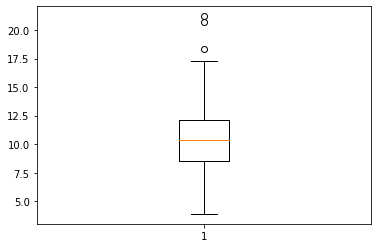

(0.0, 60.0)

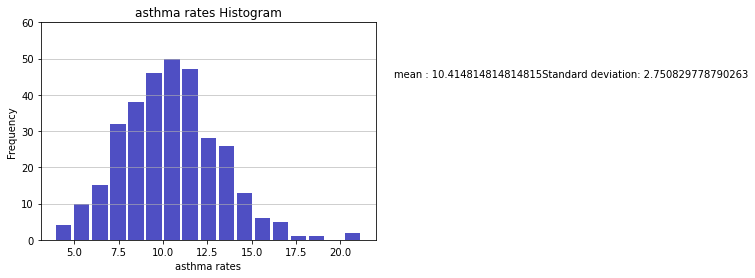

In [2]:
data_orig = pd.read_csv('datasetdone.csv') # open the csv file to see the data
data=data_orig.copy()
#Find a suitable cutt-off value for the asthma rates to assign a label.
mean=np.mean(data["asthma_rates"])
print(mean)
sd=np.std(data["asthma_rates"])
print(sd)

#draw a box plot
plt.boxplot(data["asthma_rates"])
plt.show()

#Draw a histogram
n, bins, patches = plt.hist(x=data["asthma_rates"], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('asthma rates')
plt.ylabel('Frequency')
plt.title('asthma rates Histogram')
print_statement='mean : ' + str(mean)+'Standard deviation: ' + str(sd)
plt.text(23, 45, print_statement)
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

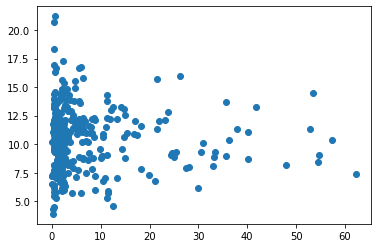

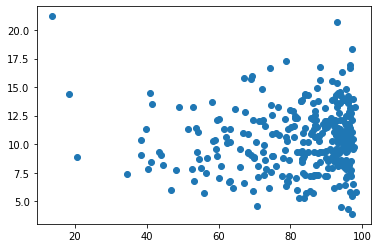

In [3]:
#draw scatter plots to check for correlations in data
plt.scatter(data['black'], data['asthma_rates'])
plt.show()
plt.scatter(data['white'], data['asthma_rates'])
plt.show()

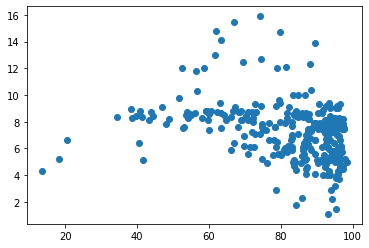

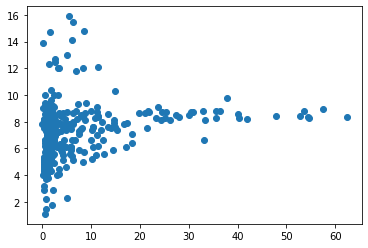

In [4]:
plt.scatter(data['white'], data['pm2.5'])
plt.show()

plt.scatter(data['black'], data['pm2.5'])
plt.show()

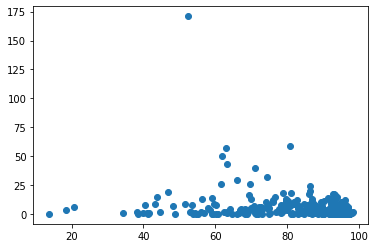

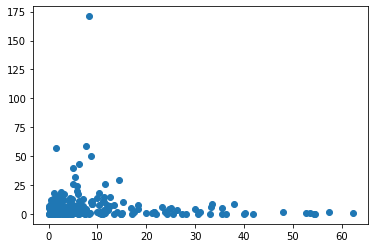

In [5]:
plt.scatter(data['white'], data['num_waste_facilities'])
plt.show()
plt.scatter(data['black'], data['num_waste_facilities'])
plt.show()

In [6]:
#Create four classes using the following cutoff points
lowerlim=mean-sd
mediumlim=mean
upperlim=mean+sd
labels=[]
n_labels=[0,0,0,0]
#go through each example and set the correct label
for i in range(len(data["asthma_rates"])):
    if (data["asthma_rates"][i] <= lowerlim):
        n_labels[0] += 1
        labels.append("LR") #lowest risk
    elif (data["asthma_rates"][i] >= upperlim):
        n_labels[3] += 1
        labels.append("HR") #highest risk
    elif ((data["asthma_rates"][i] >= lowerlim) & (data["asthma_rates"][i] <= mediumlim)):
        n_labels[1] += 1        
        labels.append("SLR") #slightly low risk
    else:
        n_labels[2] += 1
        labels.append("SHR") #slightly higher risk

#Remove asthma_rates(label)
data.pop("asthma_rates")

#remove state and county names
data.pop('State')
data.pop('County')


0        Alameda
1         Alpine
2         Amador
3          Butte
4      Calaveras
         ...    
319      Webster
320       Wetzel
321         Wirt
322         Wood
323      Wyoming
Name: County, Length: 324, dtype: object

In [7]:
def standardizer(X):
    """
    This function performs standardization on data inputed using StandardScaler
    """
       
    columns=X.columns
    scale= StandardScaler()
    scaled_data = preprocessing.scale(X) 
    X = pd.DataFrame(scaled_data, columns = columns)
    return X
    

In [8]:
def pcaer(X):
    pca = PCA(.95)
    pca.fit(X)
    X = pca.transform(X)
    return X

In [9]:
def printWeights(features, weights):
    """
    Pretty-print the model weights.
    features contains the name of each feature and weights is an array type of the same length.
    You may need to modify this function depending on your implementation
    """
    if "bias" not in features:
        features = list(features)+["bias"]
    print("\t%30s %10s" % ("Feature", "Weight"))
    for i in range(len(features)):
        print("\t%30s %10.5f" % (features[i], weights[i]))

Accuracy for SKlearn SGDClassifier: 30.00%
Coefficients and intercept for SKlearn SGDClassifier: 
	                       Feature     Weight
	          num_waste_facilities    0.00900
	                         pm2.5    0.22729
	                         white    2.71715
	                         black    0.19290
	                         asian    0.05275
	                      hispanic    0.24450
	               native_american    0.24200
	                         other    0.08270
	                    population -6133.23550
	                          bias    0.03350


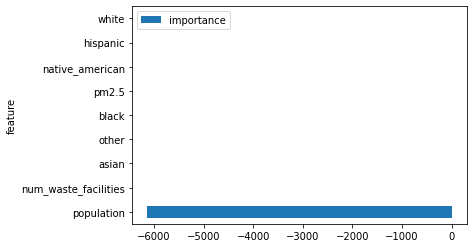

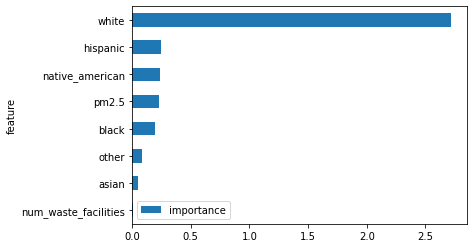

In [15]:
alpha = .001 #learning rate

data_processed_orig=data

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(data_processed_orig, labels, test_size=0.4, random_state=0)

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()

"""
 Create a logistic regression SGDClassifier with no hypertuning
"""

sgd = SGDClassifier(loss='log', max_iter=1,shuffle=False, tol=None, penalty='none', learning_rate='constant', eta0 = alpha)
sgd.fit(X_train,y_train)

#SGD model weights:
print("Accuracy for SKlearn SGDClassifier: %0.2f%%" % (sgd.score(X_test,y_test)*100))
print("Coefficients and intercept for SKlearn SGDClassifier: ")
weights = list(sgd.coef_[0]) + list(sgd.intercept_) 
printWeights(X_train.columns,  weights)

#graph feature importance
log_reg_feature_importance = pd.DataFrame(X_train.columns, columns = ["feature"])
log_reg_feature_importance['importance']= weights[:9]
log_reg_feature_importance = log_reg_feature_importance.sort_values(by = ["importance"], ascending=True)
ax = log_reg_feature_importance.plot.barh(x='feature', y='importance')
plt.show()

#graph without population to show data better
log_reg_feature_importance = pd.DataFrame(X_train.columns, columns = ["feature"])
log_reg_feature_importance['importance']= weights[:9]
log_reg_feature_importance.drop(log_reg_feature_importance.index[[8]],inplace=True)
log_reg_feature_importance = log_reg_feature_importance.sort_values(by = ["importance"], ascending=True)
ax = log_reg_feature_importance.plot.barh(x='feature', y='importance')
plt.show()

In [38]:
#Normalize and use GridCV for log regression
X=data_processed_orig.copy()
y= labels.copy()

#create objects to use in pipeline
standard_scl = StandardScaler() #normalize data
pca = decomposition.PCA()
log_reg = linear_model.LogisticRegression(random_state=0)

#create pipeline
pipe = Pipeline(steps=[('standard_slc', standard_scl),
                           ('pca', pca),
                           ('logistic_reg', log_reg)])
#create parameters for each object
n_components = list(range(1,X.shape[1]+1,1)) #for PCA components, range from 1 to features length+1

C = np.logspace(-2, 1, 50) #c value in log_regression

#parameters dictionary
parameters = {'pca__n_components':n_components,
                      'logistic_reg__C':C}

#GridSearch
grid = GridSearchCV(pipe, parameters,cv=4)
grid.fit(X_train,y_train)


print("Score", grid.score(X_test,y_test))
print('Best C:', grid.best_estimator_.get_params()['logistic_reg__C'])
print('Best Number Of Components:', grid.best_estimator_.get_params()['pca__n_components'])
print()
print(grid.best_estimator_.get_params()['logistic_reg'])

Score 0.2923076923076923
Best C: 0.020235896477251575
Best Number Of Components: 4

LogisticRegression(C=0.020235896477251575, random_state=0)


In [41]:
# testing what the ouput would be if data is not standardized

#test code to normalize and use GridCV for log regression
X=data_processed_orig.copy()
y= labels.copy()

#create objects to use in pipeline
standard_scl = StandardScaler() #normalize data
pca = decomposition.PCA()
log_reg = linear_model.LogisticRegression(random_state=0)

#create pipeline
pipe = Pipeline(steps=[('pca', pca),
                      ('logistic_reg', log_reg)])
#create parameters for each object
n_components = list(range(1,X.shape[1]+1,1)) #for PCA components, range from 1 to features length+1

C = np.logspace(-2, 2, 50) #c value in log_regression

#parameters dictionary
parameters = {'pca__n_components':n_components,
                     'logistic_reg__C':C}

grid = GridSearchCV(pipe, parameters,cv=4)
grid.fit(X_train,y_train)
print("Score", grid.score(X_test,y_test))

print('Best C:', grid.best_estimator_.get_params()['logistic_reg__C'])
print('Best Number Of Components:', grid.best_estimator_.get_params()['pca__n_components'])
print()
print(grid.best_estimator_.get_params()['logistic_reg'])

Score 0.2923076923076923
Best C: 0.09540954763499938
Best Number Of Components: 4

LogisticRegression(C=0.09540954763499938, random_state=0)


Accuracy for SKlearn SGDClassifier: 29.23%
Coefficients and intercept for SKlearn SGDClassifier: 
	                       Feature     Weight
	          num_waste_facilities   -0.00292
	                         pm2.5   -0.02760
	                         white   -0.03955
	                         black    0.01645
	                         asian   -0.04489
	                      hispanic   -0.02464
	               native_american    0.11049
	                         other    0.00889
	                    population   -0.03882
	                          bias   -0.22399


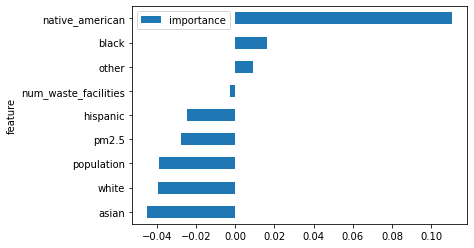

In [42]:
#creating logisitic regression classifier with best parameters determined by GridSearchCV
X_train=standardizer(X_train_orig.copy())
y_train=y_train_orig.copy()
X_test=standardizer(X_test_orig.copy())
y_test=y_test_orig.copy()
ideal_log_reg = linear_model.LogisticRegression(C=0.01, random_state=0)
ideal_log_reg.fit(X_train,y_train)

#SGD model weights:
print("Accuracy for SKlearn SGDClassifier: %0.2f%%" % (ideal_log_reg.score(X_test,y_test)*100))
print("Coefficients and intercept for SKlearn SGDClassifier: ")
weights = list(ideal_log_reg.coef_[0]) + list(ideal_log_reg.intercept_) 
printWeights(X_train.columns,  weights)

#graph feature importance
log_reg_feature_importance = pd.DataFrame(X_train.columns, columns = ["feature"])
log_reg_feature_importance['importance']= weights[:9]
log_reg_feature_importance = log_reg_feature_importance.sort_values(by = ["importance"], ascending=True)
ax = log_reg_feature_importance.plot.barh(x='feature', y='importance')
plt.show()

parameter	 train accurary	 test accuracy	
0.01 		 0.408 		 0.312 	
0.011 		 0.406 		 0.315 	
0.011 		 0.41 		 0.315 	
0.012 		 0.41 		 0.318 	
0.013 		 0.412 		 0.321 	
0.014 		 0.414 		 0.315 	
0.015 		 0.415 		 0.315 	
0.016 		 0.413 		 0.315 	
0.017 		 0.414 		 0.315 	
0.019 		 0.412 		 0.315 	
0.02 		 0.415 		 0.315 	
0.022 		 0.417 		 0.312 	
0.023 		 0.42 		 0.321 	
0.025 		 0.418 		 0.318 	
0.027 		 0.42 		 0.315 	
0.028 		 0.422 		 0.315 	
0.031 		 0.421 		 0.318 	
0.033 		 0.421 		 0.324 	
0.035 		 0.421 		 0.321 	
0.038 		 0.419 		 0.318 	
0.04 		 0.42 		 0.315 	
0.043 		 0.422 		 0.312 	
0.046 		 0.42 		 0.309 	
0.05 		 0.422 		 0.302 	
0.053 		 0.425 		 0.306 	
0.057 		 0.425 		 0.309 	
0.061 		 0.427 		 0.309 	
0.066 		 0.425 		 0.306 	
0.071 		 0.427 		 0.306 	
0.076 		 0.427 		 0.312 	
0.081 		 0.427 		 0.309 	
0.087 		 0.424 		 0.315 	
0.093 		 0.425 		 0.318 	
0.1 		 0.421 		 0.315 	
0.107 		 0.421 		 0.312 	
0.115 		 0.422 		 0.299 	
0.123 		 0.421 		 0.299 	
0.132 		

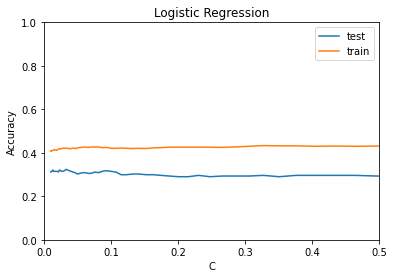

In [43]:
    #creating validation curves for log_reg
    X=standardizer(data_processed_orig.copy())
    y= labels.copy()
    param_range=np.logspace(-2, 1, 100)
    clf = linear_model.LogisticRegression(random_state=0)
    train,test = validation_curve(clf, X, y,param_name='C',param_range=param_range,cv=4)
    
    #calculate the average of the test and train scores from all folds
    sum_test=np.sum(test,axis=1)
    sum_train=np.sum(train,axis=1)
    avg_test=sum_test/4
    avg_train=sum_train/4
    print("parameter\t","train accurary\t","test accuracy\t")
    
    for i in range(len(param_range)):
        print(round(param_range[i],3),"\t\t",round(avg_train[i],3),"\t\t",round(avg_test[i],3),"\t")
   
    #graphing validation curves
    fig, ax = plt.subplots() 
    ax.set_ylim(0,1)
    ax.set_xlim(0,.5)
    ax.plot(param_range,avg_test,label="test")
    ax.plot(param_range,avg_train,label="train")
    ax.set_xlabel('C')  # Add an x-label to the axes.
    ax.set_ylabel("Accuracy")  # Add a y-label to the axes.
    ax.set_title("Logistic Regression")  # Add a title to the axes.    
    ax.legend()

In [44]:
#creating a pipeline for decision tree classifier
pipe_steps=[('scaler',StandardScaler()),('pca', pca),('decsT',DecisionTreeClassifier(random_state=0))]

pipeline = Pipeline(pipe_steps)

#parameters for gridsearch
check_params={'decsT__max_features': ['sqrt','auto','log2', None],
              'decsT__ccp_alpha':np.linspace(-1,1,5),
              'decsT__criterion':['gini','entropy'],
              'decsT__class_weight': ['balanced',None],
              'decsT__max_depth': np.arange(0,15)
               }

create_grid =GridSearchCV(pipeline,param_grid=check_params,cv=4)
create_grid.fit(X_train,y_train)

print("score for 4 fold CV := %3.2f" %(create_grid.score(X_test,y_test)))
print("!!! best fit parameters from GridSearchCV !!!!")
print(create_grid.best_params_)

score for 4 fold CV := 0.34
!!! best fit parameters from GridSearchCV !!!!
{'decsT__ccp_alpha': 0.0, 'decsT__class_weight': None, 'decsT__criterion': 'entropy', 'decsT__max_depth': 2, 'decsT__max_features': 'sqrt'}


In [45]:
#without the Standard Scalar just to check

pipe_steps=[('pca', pca),('decsT',DecisionTreeClassifier(random_state=0))]


check_params={'decsT__max_features': ['int','float','sqrt','auto','log2',None],
              'decsT__ccp_alpha':np.linspace(-1,1,5),
              'decsT__criterion':['gini','entropy'],
              'decsT__class_weight': ['balanced',None],
              'decsT__max_depth': np.arange(0,15)
               }
pipeline = Pipeline(pipe_steps)

create_grid =GridSearchCV(pipeline,param_grid=check_params,cv=4)
create_grid.fit(X_train,y_train)
print("score for 4 fold CV := %3.2f" %(create_grid.score(X_test,y_test)))
print("!!! best fit parameters from GridSearchCV !!!!")
print(create_grid.best_params_)


score for 4 fold CV := 0.30
!!! best fit parameters from GridSearchCV !!!!
{'decsT__ccp_alpha': 0.0, 'decsT__class_weight': None, 'decsT__criterion': 'gini', 'decsT__max_depth': 4, 'decsT__max_features': 'sqrt'}


We see that we do not want to class balance, and that the most important feature seems to max_depth. We would therefore want to focus on the max_depth and finetune that through validation curves. The best decision criteria seems to be entropy. Standardizing the data seems to help.

parameter	 train accurary	 test accuracy	
1 		 0.389 		 0.333 	
2 		 0.433 		 0.327 	
3 		 0.487 		 0.312 	
4 		 0.547 		 0.312 	
5 		 0.606 		 0.275 	
6 		 0.662 		 0.265 	
7 		 0.716 		 0.272 	
8 		 0.769 		 0.299 	
9 		 0.818 		 0.287 	
10 		 0.864 		 0.278 	
11 		 0.901 		 0.256 	
12 		 0.935 		 0.262 	
13 		 0.957 		 0.241 	
14 		 0.97 		 0.25 	
15 		 0.979 		 0.238 	
16 		 0.987 		 0.244 	
17 		 0.992 		 0.25 	
18 		 0.997 		 0.238 	
19 		 0.999 		 0.238 	
20 		 1.0 		 0.241 	
21 		 1.0 		 0.241 	
22 		 1.0 		 0.241 	
23 		 1.0 		 0.241 	
24 		 1.0 		 0.241 	
25 		 1.0 		 0.241 	
26 		 1.0 		 0.241 	
27 		 1.0 		 0.241 	
28 		 1.0 		 0.241 	
29 		 1.0 		 0.241 	
30 		 1.0 		 0.241 	
31 		 1.0 		 0.241 	
32 		 1.0 		 0.241 	
33 		 1.0 		 0.241 	
34 		 1.0 		 0.241 	
35 		 1.0 		 0.241 	
36 		 1.0 		 0.241 	
37 		 1.0 		 0.241 	
38 		 1.0 		 0.241 	
39 		 1.0 		 0.241 	
40 		 1.0 		 0.241 	
41 		 1.0 		 0.241 	
42 		 1.0 		 0.241 	
43 		 1.0 		 0.241 	
44 		 1.0 		 0.241 	
45 		 1.

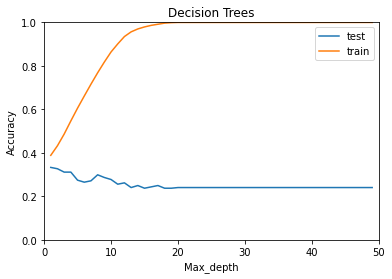

In [46]:
#Draw validation curves for the Decision Tree classifier

X=standardizer(data_processed_orig.copy())
y= labels.copy()
param_range=np.arange(1, 50)
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=0), param_name="max_depth",
    X=X,
    y=y,
    param_range=param_range, cv=4, scoring="accuracy"
)

#calculate the average of the test and train scores from all folds
sum_test=np.sum(test_scores,axis=1)
sum_train=np.sum(train_scores,axis=1)
avg_test=sum_test/4
avg_train=sum_train/4


print("parameter\t","train accurary\t","test accuracy\t")

for i in range(len(param_range)):
    print(param_range[i],"\t\t",round(avg_train[i],3),"\t\t",round(avg_test[i],3),"\t")
    
fig, ax = plt.subplots() 

ax.set_ylim(0,1)
ax.set_xlim(0,50)
ax.plot(param_range,avg_test,label="test")
ax.plot(param_range,avg_train,label="train")
ax.set_xlabel('Max_depth')  # Add an x-label to the axes.
ax.set_ylabel("Accuracy")  # Add a y-label to the axes.
ax.set_title("Decision Trees")  # Add a title to the axes.    
ax.legend()


It seems like our graph overfits pretty quickly.

train score:  0.5360824742268041
test_score:  0.3076923076923077


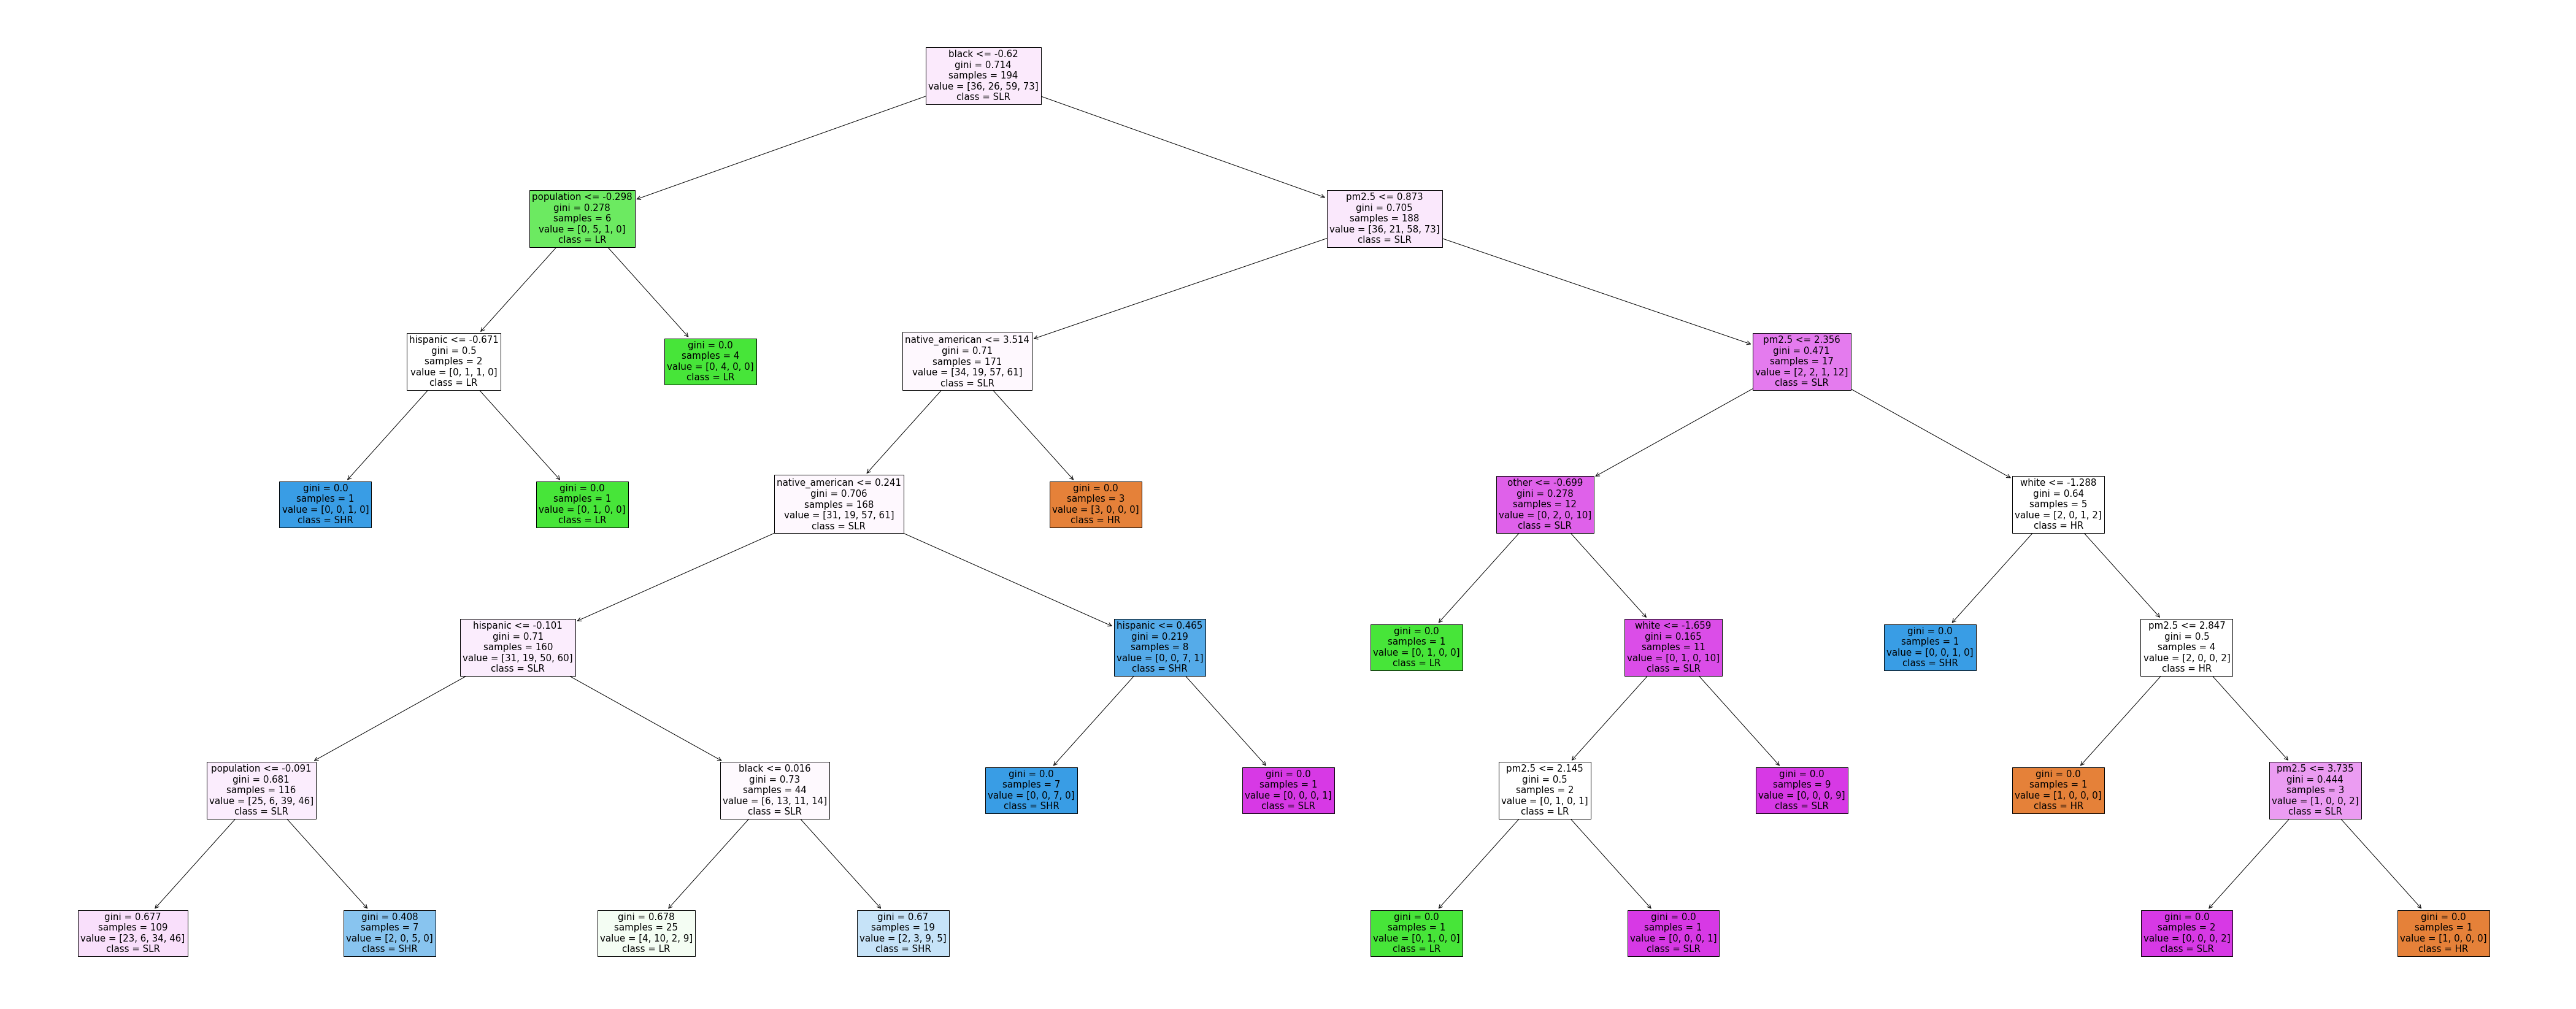

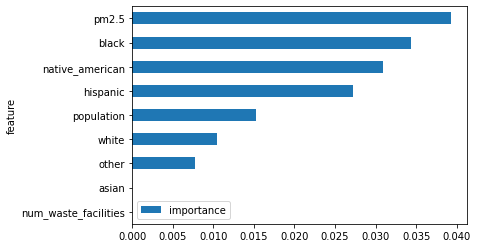

In [28]:
#we train an ideal Decision tree and display it's feature importance graphs.
ideal_DecsTree=DecisionTreeClassifier(max_depth=6,random_state=0)
ideal_DecsTree.fit((standardizer(X_train_orig.copy())),y_train_orig.copy())

train_score = ideal_DecsTree.score((standardizer(X_train_orig.copy())),y_train_orig.copy())
test_score  = ideal_DecsTree.score((standardizer(X_test_orig.copy())),y_test_orig.copy())
print("train score: ", train_score)
print("test_score: ", test_score)

#decision tree diagram
fig = plt.figure(figsize=(75,30))
a = plot_tree(ideal_DecsTree, 
                   fontsize=15,
                   feature_names=X_train_orig.columns,  
                   class_names=np.unique(y_train_orig.copy()),
                   filled=True)

plt.savefig('Final tree.jpg',format='jpg',bbox_inches = "tight")

#compute feature importance for DT and display
feat_importance = ideal_DecsTree.tree_.compute_feature_importances(normalize=False)
dt_feature_importance = pd.DataFrame(X_train_orig.columns, columns = ["feature"])
dt_feature_importance['importance']= feat_importance[:9]
dt_feature_importance = dt_feature_importance.sort_values(by = ["importance"], ascending=True)
ax = dt_feature_importance.plot.barh(x='feature', y='importance')
plt.show()


In [30]:
X_train=standardizer(X_train_orig.copy())
y_train=y_train_orig.copy()

X_test=standardizer(X_test_orig.copy())
y_test=y_test_orig.copy()

#creating a Random Forest classifier
clf_RF = RandomForestClassifier(random_state=0)


steps=[('scaler',StandardScaler()),('pca', pca),('rf',clf_RF)]


pipe_rfsteps=Pipeline(steps)

#parameters for Random Forest
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num = 10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]

params_rf = {
       'rf__bootstrap': bootstrap, 
       'rf__n_estimators':n_estimators                                                                  
        }
       
       
#grid search
create_grid =GridSearchCV(pipe_rfsteps,param_grid=params_rf,cv=4)
create_grid.fit(X_train,y_train)
print()
print("score for 4 fold CV := %3.2f" %(create_grid.score(X_test,y_test)))
print("!!! best fit parameters from GridSearchCV !!!!")
print(create_grid.best_params_)



score for 4 fold CV := 0.30
!!! best fit parameters from GridSearchCV !!!!
{'rf__bootstrap': True, 'rf__n_estimators': 67}


parameter	 train accurary	 test accuracy	
1 		 0.774 		 0.296 	
2 		 0.781 		 0.275 	
3 		 0.861 		 0.284 	
4 		 0.913 		 0.281 	
5 		 0.938 		 0.269 	
6 		 0.95 		 0.269 	
7 		 0.961 		 0.265 	
8 		 0.984 		 0.275 	
9 		 0.99 		 0.302 	
10 		 0.989 		 0.299 	
11 		 0.99 		 0.29 	
12 		 0.988 		 0.29 	
13 		 0.994 		 0.284 	
14 		 0.996 		 0.287 	
15 		 1.0 		 0.299 	
16 		 0.998 		 0.293 	
17 		 1.0 		 0.306 	
18 		 1.0 		 0.296 	
19 		 1.0 		 0.315 	
20 		 1.0 		 0.296 	
21 		 1.0 		 0.281 	
22 		 1.0 		 0.287 	
23 		 1.0 		 0.287 	
24 		 0.999 		 0.293 	
25 		 1.0 		 0.296 	
26 		 1.0 		 0.299 	
27 		 1.0 		 0.302 	
28 		 1.0 		 0.309 	
29 		 1.0 		 0.296 	
30 		 1.0 		 0.281 	
31 		 1.0 		 0.284 	
32 		 1.0 		 0.29 	
33 		 1.0 		 0.296 	
34 		 1.0 		 0.281 	
35 		 1.0 		 0.281 	
36 		 1.0 		 0.29 	
37 		 1.0 		 0.287 	
38 		 1.0 		 0.29 	
39 		 1.0 		 0.284 	
40 		 1.0 		 0.296 	
41 		 1.0 		 0.299 	
42 		 1.0 		 0.293 	
43 		 1.0 		 0.299 	
44 		 1.0 		 0.302 	
45 		 1.0 		 0.306 

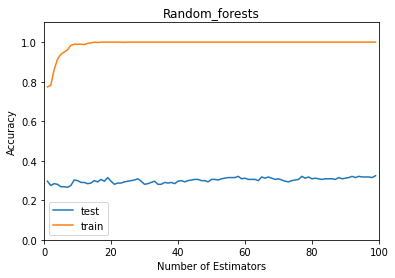

In [31]:
X=data_processed_orig.copy()
y= labels.copy()

#creating validation curve for RF
param_range=np.arange(1, 100)
train_scores, test_scores = validation_curve(
   RandomForestClassifier(random_state=0), param_name="n_estimators",
    X=X, y=y, param_range=param_range, cv=4, scoring="accuracy"
)

    
#calculate the average of the test and train scores from all folds
sum_test=np.sum(test_scores,axis=1)
sum_train=np.sum(train_scores,axis=1)
avg_test=sum_test/4
avg_train=sum_train/4


print("parameter\t","train accurary\t","test accuracy\t")

for i in range(len(param_range)):
    print(param_range[i],"\t\t",round(avg_train[i],3),"\t\t",round(avg_test[i],3),"\t")
    
    
fig, ax = plt.subplots() 

ax.set_ylim(0,1.1)
ax.set_xlim(0,100)
ax.plot(param_range,avg_test,label="test")
ax.plot(param_range,avg_train,label="train")
ax.set_xlabel('Number of Estimators')  # Add an x-label to the axes.
ax.set_ylabel("Accuracy")  # Add a y-label to the axes.
ax.set_title("Random_forests")  # Add a title to the axes.    
ax.legend()

0.38461538461538464


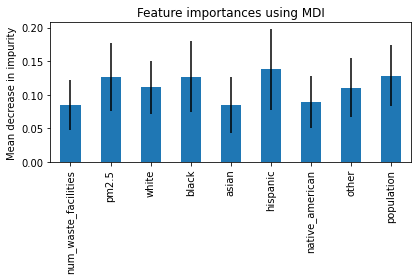

In [27]:
#we train a ideal Random Forest Classifier to find the feature importances using MDI and permutations(in next cell).

ideal_forest = RandomForestClassifier(random_state=0,n_estimators=45)
ideal_forest.fit(X_train, y_train)
print(ideal_forest.score(X_test,y_test))
importances = ideal_forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in ideal_forest.estimators_], axis=0)


forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

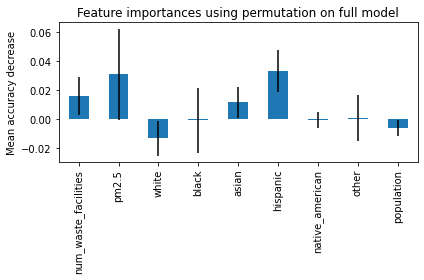

In [28]:
#we train a ideal Random Forest Classifier to find the feature importances.

result = permutation_importance(
    ideal_forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [34]:
#Create Pipeline and compute Grid Search for SVMs

def SVMPipeline(): 
    X=data.copy()
    y= labels.copy()
    steps = [('scaler', StandardScaler()), ('SVM', SVC(random_state=0))]

    pipeline = Pipeline(steps) # define the pipeline object

 
    parameters = {'SVM__C':[0.001,0.1,10,100,1000],#10e5],
                  'SVM__gamma':[0.1,0.01,0.001],
                  'SVM__kernel':['rbf', 'linear']}
   
    #we perform gridsearch on SVM
    grid = GridSearchCV(pipeline, param_grid=parameters, cv=4)
    grid.fit(X_train, y_train)
    print("score = %3.2f" %(grid.score(X_test,y_test)))
    print(grid.best_params_)


SVMPipeline()

score = 0.32
{'SVM__C': 100, 'SVM__gamma': 0.01, 'SVM__kernel': 'rbf'}


parameter	 train accurary	 test accuracy	
1e-06 		 0.346 		 0.346 	
1e-05 		 0.346 		 0.346 	
0.0001 		 0.346 		 0.346 	
0.001 		 0.346 		 0.346 	
0.01 		 0.387 		 0.352 	
0.1 		 0.42 		 0.315 	
1 		 0.435 		 0.33 	
10 		 0.448 		 0.296 	
100 		 0.449 		 0.275 	
1000 		 0.449 		 0.281 	


	                       Feature     Weight
	          num_waste_facilities    0.32171
	                         pm2.5   -0.02886
	                         white    0.87039
	                         black    0.96960
	                         asian    0.12785
	                      hispanic   -1.13122
	               native_american    0.49512
	                         other    1.06710
	                    population   -0.44875
	                          bias    0.64707


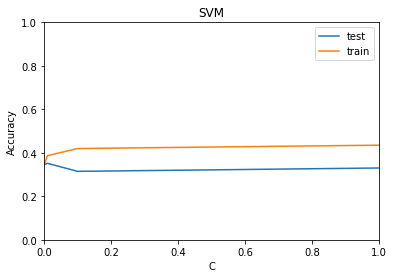

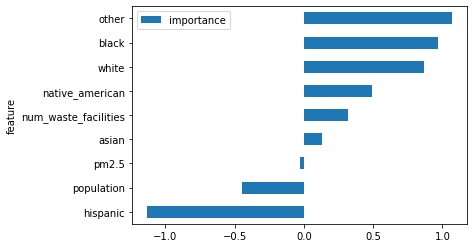

In [37]:
 #we draw validation curves for SVM using Gamma variable, and then we plot feature importances.
X=standardizer(data_processed_orig.copy())
y= labels.copy()

#create an ideal svm classifier
svm_clf = SVC(kernel='linear',gamma=0.1,random_state=0)

#validation curve
param_range=[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
train,test = validation_curve(svm_clf, X, y,param_name='C',param_range=param_range,cv=4)

#calculate the average of the test and train scores from all folds
sum_test=np.sum(test,axis=1)
sum_train=np.sum(train,axis=1)
avg_test=sum_test/4
avg_train=sum_train/4

print("parameter\t","train accurary\t","test accuracy\t")
for i in range(len(param_range)):
    print(param_range[i],"\t\t",round(avg_train[i],3),"\t\t",round(avg_test[i],3),"\t")
print()

#plot validation curve
fig, ax = plt.subplots() 

ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.plot(param_range,avg_test,label="test")
ax.plot(param_range,avg_train,label="train")
ax.set_xlabel('C')  # Add an x-label to the axes.
ax.set_ylabel("Accuracy")  # Add a y-label to the axes.
ax.set_title("SVM")  # Add a title to the axes.    
ax.legend()
print()

#create weights for linear SVM
svm_clf.fit(X_train,y_train)
weights = list(svm_clf.coef_[0]) + list(svm_clf.intercept_) 
printWeights(X.columns,  weights)

#graph feature importance
svm_feature_importance = pd.DataFrame(X_train.columns, columns = ["feature"])
svm_feature_importance['importance']= weights[:9]
svm_feature_importance = svm_feature_importance.sort_values(by = ["importance"], ascending=True)
ax = svm_feature_importance.plot.barh(x='feature', y='importance')
plt.show()